<a href="https://colab.research.google.com/github/AminAmbike/Unsupervised-Learning-for-Algorithmic-Trading/blob/main/Unsupervised_Learning_Algorithmic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring An Unsupervised Learning Trading Strategy For S&P Stocks

In this analysis, I will explore using Unsupervised Learning to create a momentum based investing strategy that analyzes the Relative Strength Index (RSI) technical indicator  for choosing stocks to hold in a portfolio. Technical indicators are mathematical calculations used by traders, that use histroical data to predict future price movements of stocks, and other assets. We will perform analysis of one such technical indicator (RSI) using unsupervised learning to identify potentially lucrative stocks, and use the Markowitz Model and Sharpe Ratios to choose the optimal portfolio of these stocks, mitigating risk.

### 1. Import Dependencies And Download Historical Data (ex. closing price, volume) For S&P 500 Stocks
- Packages Needed: pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt.
- We download our data from the Yahoo Finance API.
- We will test our strategy on the past 8 years of historical stock returns.

In [3]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import pandas_ta
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import warnings
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
warnings.filterwarnings("ignore")

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['symbol'] = sp500['Symbol'].str.replace('.','-')

symbol_list = sp500['symbol'].unique().tolist()

end_date = '2024-08-16'

start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

# we will download our stock data from the Yahoo Finance API
df = yf.download(tickers = symbol_list, start=start_date, end=end_date)
df.index = df.index.tz_localize(None)


df = df.stack()
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-16 A        45.340328   48.279999   48.540001   48.119999   48.270000   
           AAL      35.423317   36.750000   36.790001   35.630001   35.669998   
           AAPL     25.222878   27.344999   27.557501   27.302500   27.407499   
           ABBV     47.278488   66.739998   67.610001   66.500000   67.129997   
           ABT      38.803585   44.919998   45.080002   44.820000   45.020000   
...                       ...         ...         ...         ...         ...   
2024-08-15 XYL     132.836975  133.190002  134.270004  131.779999  132.949997   
           YUM     137.125793  137.809998  138.160004  136.779999  137.919998   
           ZBH     109.900002  109.900002  110.250000  108.910004  109.000000   
           ZBRA    343.209991  343.209991  344.399994  338.700012  338.769989   
           ZTS     184.080002  184.080002  186.169998  182.710007  184.520004   

Price                   volume  
date       ticker               
2016-08-16 A         3176000.0  
           AAL       9385000.0  
           AAPL    135177600.0  
           ABBV      7147600.0  
           ABT       7584400.0  
...                        ...  
2024-08-15 XYL        739000.0  
           YUM       1134100.0  
           ZBH       1151800.0  
           ZBRA       307200.0  
           ZTS       1891900.0  

[991539 rows x 6 columns]

## 2. Calculate Dollar Volume And RSI For Each Stock
- The Relative Strength Index is a popular momentum oscillator used in technical analysis to measure the velocity of price movements.
- Typically calculated over a 14-day period, it measures the ratio between the average gain over a given period by the avaerage loss:
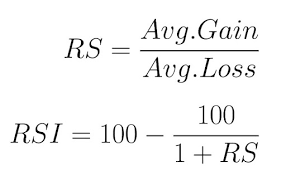

- Higher RSI values (> 70) typically indicate a stock is overbought (typically an indicator to sell), and lower RSI values ( < 30) indicate a stock is oversold (typically an indicator to buy), however what if we use a momentum based investment strategy that specifcally clusters stocks based on RSI and holds those with the most upward momentum?
- Dollar Volume -> Represents the total trading value of an asset, calculated as price multiplied by volume. We will use this later to measure liquidity.

In [4]:
#RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))


# Dollar Volume -> for measuring liquidity
df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-16 A        45.340328   48.279999   48.540001   48.119999   48.270000   
           AAL      35.423317   36.750000   36.790001   35.630001   35.669998   
           AAPL     25.222878   27.344999   27.557501   27.302500   27.407499   
           ABBV     47.278488   66.739998   67.610001   66.500000   67.129997   
           ABT      38.803585   44.919998   45.080002   44.820000   45.020000   
...                       ...         ...         ...         ...         ...   
2024-08-15 XYL     132.836975  133.190002  134.270004  131.779999  132.949997   
           YUM     137.125793  137.809998  138.160004  136.779999  137.919998   
           ZBH     109.900002  109.900002  110.250000  108.910004  109.000000   
           ZBRA    343.209991  343.209991  344.399994  338.700012  338.769989   
           ZTS     184.080002  184.080002  186.169998  182.710007  184.520004   

Price                   volume        rsi  dollar_volume  
date       ticker                                         
2016-08-16 A         3176000.0        NaN     144.000882  
           AAL       9385000.0        NaN     332.447830  
           AAPL    135177600.0        NaN    3409.568046  
           ABBV      7147600.0        NaN     337.927722  
           ABT       7584400.0        NaN     294.301910  
...                        ...        ...            ...  
2024-08-15 XYL        739000.0  48.772634      98.166525  
           YUM       1134100.0  59.488550     155.514362  
           ZBH       1151800.0  50.288549     126.582822  
           ZBRA       307200.0  60.159903     105.434109  
           ZTS       1891900.0  54.887731     348.260955  

[991539 rows x 8 columns]

## 3. Aggregate To Monthly Level And Filter The Top 150 Most Liquid Stocks For Each Month
- Trading more liquid stocks can allow for faster trade execution in live trading algorithms, it can also resut in less price slippage.
- We convert daily data to month-end in order to reduce training time for the Machine Learning model.

In [5]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open','high','low','close']]
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1).dropna()
data

dollar_volume   adj close        rsi
date       ticker                                      
2016-09-30 A           79.965592   44.332626  52.872961
           AAL        272.390879   35.288376  51.560546
           AAPL      4725.075114   26.069180  57.026198
           ABBV       296.328717   44.678677  39.339335
           ABT        277.293735   36.531704  47.215163
...                          ...         ...        ...
2024-08-31 XYL        153.155713  132.836975  48.772634
           YUM        278.814489  137.125793  59.488550
           ZBH        171.734459  109.900002  50.288549
           ZBRA       136.258067  343.209991  60.159903
           ZTS        413.857035  184.080002  54.887731

[47286 rows x 3 columns]

- Calculate 5-year rolling average of dollar volume for each stock before filtering -> select 150 most liquid stocks using dollar volume.

In [6]:
data['dollar_volume']=(data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12,min_periods=1).mean().stack())
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'],axis=1)
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)
data

adj close        rsi
date       ticker                       
2016-09-30 AAL      35.288376  51.560546
           AAPL     26.069180  57.026198
           ABBV     44.678677  39.339335
           ABT      36.531704  47.215163
           ACN     107.262169  72.060371
...                       ...        ...
2024-08-31 VZ       40.040001  47.722825
           WFC      54.570000  44.511297
           WMT      72.972000  66.405001
           XOM     118.730003  58.187359
           ZTS     184.080002  54.887731

[14304 rows x 2 columns]

## 4. Calculate Returns Over Different Periods
- To capture time series momentum patterns, calculate historical returns over various monthly intervals.


In [7]:
# calculate weekly returns for different time horizons as features
def calculate_return(df):
  outlier_cutoff = 0.005  # 99.5 percentile is our cutoff
  lags = [1,2,3,6,9,12]

  for lag in lags:
    df[f'return_{lag}m'] = (df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))


  return df

data = data.groupby(level=1,group_keys=False).apply(calculate_return).dropna()
data

adj close        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                           
2017-09-30 AAL      46.185772  53.050776   0.061466  -0.028700  -0.018447   
           AAPL     36.166767  45.768834  -0.060244   0.019956   0.024187   
           ABBV     65.390610  70.568564   0.180080   0.124946   0.073326   
           ABT      47.232563  63.665119   0.047507   0.041630   0.033465   
           ACN     121.064758  56.250126   0.032961   0.023971   0.029801   
...                       ...        ...        ...        ...        ...   
2024-08-31 VRTX    472.000000  46.875715  -0.047850   0.003493   0.012050   
           VZ       40.040001  47.722825  -0.011846  -0.006626  -0.003697   
           WFC      54.570000  44.511297  -0.073359  -0.037783  -0.028232   
           WMT      72.972000  66.405001   0.066142   0.039608   0.036279   
           XOM     118.730003  58.187359   0.009241   0.019638   0.006849   

                   return_6m  return_9m  return_12m  
date       ticker                                    
2017-09-30 AAL      0.020186   0.002602    0.022680  
           AAPL     0.013139   0.033672    0.027658  
           ABBV     0.056376   0.042995    0.032249  
           ABT      0.033071   0.039285    0.021639  
           ACN      0.021839   0.017126    0.010139  
...                      ...        ...         ...  
2024-08-31 VRTX     0.019345   0.032219    0.025640  
           VZ       0.005481   0.010349    0.017251  
           WFC     -0.000862   0.025009    0.026006  
           WMT      0.038882   0.040144    0.026233  
           XOM      0.024219   0.019069    0.008374  

[12038 rows x 8 columns]

## 5. Fit a K-Means Clustering Algorithm For Each Month To Group Stocks Based On RSI
- By comparing RSI against the stock's return in the following month, in many instances there is a visible correlation between RSI over the past 20 days and returns over the following month.

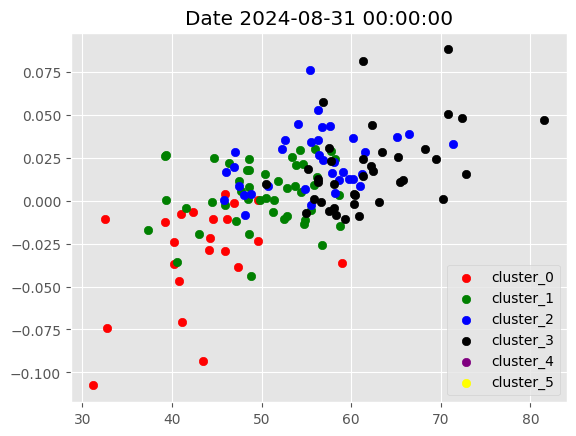
- Add x and y axis for graph


###   K-Means Clustering
  - For our trading strategy we will focus purely on exploring RSI as a technical indicator to predict future performance. Usually it is recommended to use a variety of indicators for price movements, however this analysis is purely experimental.
  - We will initialize predefined centroids for each cluster based on how we observe RSI to be distributed in the majority of cases (see above graph).
  - We will then cluster our stocks each month based on RSI, and select those from the cluster with the highest RSI.

### Initialize pre-defined centroids
- We set cluster centroids at RSI values: 30, 45, 55, 70
- This will allow us to group stocks for each month by RSI, and we can make trades based on these groupings.

In [10]:
# ensure that cluster initialization isn't random, the same clusters center around the same centroids each month
from sklearn.preprocessing import StandardScaler

target_rsi_values = [30, 45, 55, 70]

rsi_index = 1
scaler = StandardScaler()
scaled_rsi_values = scaler.fit_transform(np.array(target_rsi_values).reshape(-1, 1)).flatten()

initial_centroids = np.zeros((len(target_rsi_values), 7))
initial_centroids[:, rsi_index] = scaled_rsi_values
print(initial_centroids.shape)
initial_centroids

(4, 7)


array([[ 0.        , -1.37198868,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.34299717,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.34299717,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.37198868,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

### Standardize the data

In [11]:
from sklearn.preprocessing import StandardScaler

data = data.drop('adj close',axis=1)
features = data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
scaled_data

rsi  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                         
2017-09-30 AAL     0.107905   0.499642  -0.603264  -0.544713   0.293191   
           AAPL   -0.596366  -0.761675   0.138545   0.269381   0.101478   
           ABBV    1.802132   1.728862   1.739248   1.207672   1.277742   
           ABT     1.134468   0.354977   0.469000   0.446531   0.643722   
           ACN     0.417329   0.204234   0.199766   0.376565   0.338160   
...                     ...        ...        ...        ...        ...   
2024-08-31 VRTX   -0.489314  -0.633229  -0.112453   0.037623   0.270324   
           VZ     -0.407386  -0.260114  -0.266733  -0.263073  -0.106858   
           WFC    -0.717988  -0.897589  -0.741758  -0.731569  -0.279430   
           WMT     1.399454   0.548098   0.438174   0.500276   0.801826   
           XOM     0.604688  -0.041585   0.133702  -0.061694   0.402909   

                   return_9m  return_12m  
date       ticker                         
2017-09-30 AAL     -0.220170    0.520939  
           AAPL     0.803256    0.711471  
           ABBV     1.110334    0.887211  
           ABT      0.988148    0.481114  
           ACN      0.258241    0.040915  
...                      ...         ...  
2024-08-31 VRTX     0.755386    0.634233  
           VZ       0.035019    0.313133  
           WFC      0.517914    0.648242  
           WMT      1.016426    0.656951  
           XOM      0.322254   -0.026610  

[12038 rows x 7 columns]

### Fit K-Means Clustering algorithm

In [12]:
# For each month fit a k-means clustering algorithm to group similar assets based on their feautres
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(scaled_data):
  # ensure that cluster initialization isn't random, the same clusters center around the same centroids each month
  scaled_data['cluster'] = KMeans(n_clusters=4,random_state=0,init=initial_centroids).fit(scaled_data).labels_


  return scaled_data


clustered_data = scaled_data.dropna().groupby('date', group_keys=False).apply(get_clusters)

clustered_data



rsi  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                         
2017-09-30 AAL     0.107905   0.499642  -0.603264  -0.544713   0.293191   
           AAPL   -0.596366  -0.761675   0.138545   0.269381   0.101478   
           ABBV    1.802132   1.728862   1.739248   1.207672   1.277742   
           ABT     1.134468   0.354977   0.469000   0.446531   0.643722   
           ACN     0.417329   0.204234   0.199766   0.376565   0.338160   
...                     ...        ...        ...        ...        ...   
2024-08-31 VRTX   -0.489314  -0.633229  -0.112453   0.037623   0.270324   
           VZ     -0.407386  -0.260114  -0.266733  -0.263073  -0.106858   
           WFC    -0.717988  -0.897589  -0.741758  -0.731569  -0.279430   
           WMT     1.399454   0.548098   0.438174   0.500276   0.801826   
           XOM     0.604688  -0.041585   0.133702  -0.061694   0.402909   

                   return_9m  return_12m  cluster  
date       ticker                                  
2017-09-30 AAL     -0.220170    0.520939        1  
           AAPL     0.803256    0.711471        1  
           ABBV     1.110334    0.887211        2  
           ABT      0.988148    0.481114        2  
           ACN      0.258241    0.040915        1  
...                      ...         ...      ...  
2024-08-31 VRTX     0.755386    0.634233        1  
           VZ       0.035019    0.313133        1  
           WFC      0.517914    0.648242        1  
           WMT      1.016426    0.656951        2  
           XOM      0.322254   -0.026610        3  

[12038 rows x 8 columns]

### Visualize stats for each cluster

In [13]:
unscaled_data = scaler.inverse_transform(scaled_data)
unscaled_data = pd.DataFrame(unscaled_data, index=features.index, columns=features.columns)
unscaled_data['cluster'] = clustered_data['cluster']
pd.set_option('display.max_columns', None)
cluster_stats = unscaled_data.groupby('cluster').agg(['mean','var'])
cluster_stats

rsi            return_1m           return_2m            \
              mean        var      mean       var      mean       var   
cluster                                                                 
0        41.502346  65.736222 -0.066652  0.007455 -0.045659  0.003802   
1        47.536233  41.115607 -0.017482  0.004086 -0.009135  0.001916   
2        57.723377  48.406921  0.045426  0.003606  0.035409  0.002004   
3        61.883259  70.638704  0.106487  0.012843  0.069958  0.004906   

        return_3m           return_6m           return_9m            \
             mean       var      mean       var      mean       var   
cluster                                                               
0       -0.034319  0.002720 -0.019131  0.001536 -0.011554  0.001263   
1       -0.004468  0.001305  0.000833  0.000707  0.003259  0.000488   
2        0.029232  0.001248  0.022102  0.000623  0.018835  0.000411   
3        0.054382  0.003133  0.035604  0.001734  0.027413  0.001293   

        return_12m            
              mean       var  
cluster                       
0        -0.006983  0.000900  
1         0.004398  0.000390  
2         0.016701  0.000369  
3         0.022568  0.000980

## 6. For Each Month Select Stocks Based On The Chosen Cluster And Build a Portfolio By Maximizing Sharpe Ratio for Portfolio Optimization (Markowitz Model)
- Fiter only stocks corresponding to the cluster we choose based on our hypothesis.
- Our hypothesis is that momentum is persistent and the idea is that stocks clustered around 70 RSI should continue to outperform in the following month, thus for each month, we select stocks corresponding to cluster 3.

In [15]:
data = clustered_data
filtered_df = data[(data['cluster']==3)]

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date','ticker']).unstack().stack()

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-10-01': ['AZO',
  'BRK-B',
  'COF',
  'COP',
  'COST',
  'CSCO',
  'CVS',
  'CVX',
  'DG',
  'DLTR',
  'EOG',
  'F',
  'GS',
  'HAL',
  'HPE',
  'INTC',
  'LLY',
  'LOW',
  'MET',
  'MRO',
  'ORLY',
  'OXY',
  'PANW',
  'PFE',
  'SCHW',
  'SLB',
  'T',
  'TGT',
  'TJX',
  'UNP',
  'UPS',
  'USB',
  'VZ',
  'WFC',
  'XOM'],
 '2017-11-01': ['ABBV',
  'ADBE',
  'AMAT',
  'AMZN',
  'CAT',
  'INTC',
  'ISRG',
  'LRCX',
  'MAR',
  'MSFT',
  'MU',
  'NVDA',
  'PYPL',
  'SHW',
  'TXN'],
 '2017-12-01': ['AAL',
  'AZO',
  'BK',
  'BRK-B',
  'CL',
  'CMCSA',
  'CMG',
  'COF',
  'CVS',
  'CVX',
  'DAL',
  'DHR',
  'DIS',
  'EOG',
  'F',
  'GS',
  'IBM',
  'KR',
  'LOW',
  'LUV',
  'MCK',
  'MDLZ',
  'MDT',
  'MO',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'RTX',
  'SBUX',
  'T',
  'TGT',
  'TJX',
  'UAL',
  'ULTA',
  'UPS',
  'USB',
  'VTRS',
  'VZ',
  'WBA',
  'WFC',
  'XOM'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'DE',
  'DG',
  'DLTR',
  'FCX',
  'FDX',
  'HD',
  'LOW',
  'LUV',

### Define a Portfolio Optimization Function
- We use PyPortfolioOpt and EfficientFrontier optimizer to maximize the Sharpe Ratio of our portfolio.
- Sharpe Ratio is effectively the ratio between Expected value and Expected volatility for a given portfolio, and can be calculated using histroical returns of each stock as well as the weights of each stock that make up our portfolio.
- We also apply constraints to our optimizer to ensure no stock exceeds 10% of our portfolio or makes up less than half of equally distributed weight.
- More on Sharpe Ratio: LINK

In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
  returns = expected_returns.mean_historical_return(prices=prices,frequency=252)

  cov = risk_models.sample_cov(prices,frequency=252)

  ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov,weight_bounds=(lower_bound,0.1), solver='SCS')

  weights = ef.max_sharpe()

  return ef.clean_weights()


- Download Daily price data for our short listed stocks

In [17]:
# Download Fresh Daily Prices Data only for short listed stocks

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks, start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12), end=data.index.get_level_values('date').unique()[-1])
new_df.index = new_df.index.tz_localize(None)


new_df

[*********************100%***********************]  179 of 179 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV        ABNB         ABT   
Date                                                                    
2016-09-30  35.288364   26.069181   44.678673         NaN   36.531700   
2016-10-03  36.339016   25.946960   44.792023         NaN   36.756290   
2016-10-04  36.271538   26.057646   44.629078         NaN   36.367573   
2016-10-05  36.502888   26.069181   44.905357         NaN   36.920433   
2016-10-06  36.792053   26.262880   44.508659         NaN   37.119110   
...               ...         ...         ...         ...         ...   
2024-08-26  10.210000  227.179993  197.440002  115.709999  112.699997   
2024-08-27  10.170000  228.029999  195.919998  116.739998  113.099998   
2024-08-28  10.150000  226.490005  195.399994  117.529999  112.900002   
2024-08-29  10.390000  229.789993  195.179993  116.599998  112.760002   
2024-08-30  10.620000  229.000000  196.309998  117.309998  113.269997   

Price                                                                   \
Ticker             ACN        ADBE         ADI         ADP        ADSK   
Date                                                                     
2016-09-30  107.262177  108.540001   55.191540   74.798309   72.330002   
2016-10-03  106.112015  108.449997   55.020267   74.314919   71.180000   
2016-10-04  103.811722  108.389999   55.011703   73.924805   71.419998   
2016-10-05  103.785385  108.800003   55.388512   74.272530   73.209999   
2016-10-06  104.057556  108.559998   55.439884   74.255547   72.830002   
...                ...         ...         ...         ...         ...   
2024-08-26  336.779999  559.440002  224.726151  271.350006  256.209991   
2024-08-27  340.380005  567.820007  230.931747  274.679993  256.989990   
2024-08-28  337.390015  560.539978  226.280045  272.679993  254.619995   
2024-08-29  340.209991  569.630005  229.985474  273.359985  258.230011   
2024-08-30  341.950012  574.409973  233.919998  275.910004  258.399994   

Price                                                                  \
Ticker            AIG        ALGN        AMAT         AMD        AMGN   
Date                                                                    
2016-09-30  48.531891   93.750000   27.532539    6.910000  131.484299   
2016-10-03  48.188389   90.209999   27.322504    6.950000  131.902130   
2016-10-04  48.319244   89.459999   27.039423    6.970000  132.067627   
2016-10-05  48.989902   89.480003   27.340775    6.780000  131.823288   
2016-10-06  49.030792   89.440002   27.295113    6.960000  131.555283   
...               ...         ...         ...         ...         ...   
2024-08-26  74.610001  231.649994  196.229996  149.990005  326.779999   
2024-08-27  74.430000  236.279999  195.770004  150.500000  326.929993   
2024-08-28  75.519997  230.929993  192.889999  146.360001  329.489990   
2024-08-29  76.120003  235.149994  192.979996  145.490005  331.010010   
2024-08-30  77.050003  237.220001  197.259995  148.559998  333.829987   

Price                                                                    \
Ticker             AMT        AMZN        AVGO         AXP          AZO   
Date                                                                      
2016-09-30   94.683952   41.865501   13.514412   57.017315   768.340027   
2016-10-03   93.781631   41.837002   13.322492   56.812538   760.710022   
2016-10-04   92.411446   41.701500   13.242590   56.901573   758.539978   
2016-10-05   89.763008   42.217999   13.589610   57.590580   759.440002   
2016-10-06   90.656967   42.083000   13.645237   55.425114   761.929993   
...                ...         ...         ...         ...          ...   
2024-08-26  225.309998  175.500000  159.619995  253.880005  3157.100098   
2024-08-27  226.160004  173.119995  161.389999  255.029999  3181.850098   
2024-08-28  225.250000  170.800003  158.179993  257.089996  3196.699951   
2024-08-29  223.5

## 7. Backtesting
- Calculate daily returns for each short listed stock.
- Loop over each month's start, select the stocks for that month that we previously short listed with clustering, and calculate their optimal weights for the month using our optimizer function.
- If the maximum Sharpe Ratio optimization fails for a given month, apply equally weighted weights.
- Calculate each days portfolio return over the next month.
- effecitvley we select stocks with the highest RSI, use our optimizer to decide how much of each to hold, and then hold those stocks for a month.

In [24]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  try:

    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

    lower_bound = round(1/(len(optimization_df.columns)*2),3)
    success= False
    try:
      weights = optimize_weights(prices=optimization_df,lower_bound=lower_bound)
      weights = pd.DataFrame(weights,index=pd.Series(0))
      success = True
    except:
      print(f'Max Sharpe Optimization failed for {start_date}, Contunuing with Equal-weights')

    if not success:
      weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],index=optimization_df.columns.tolist(), columns=pd.Series(0)).T # if sharpe optimization fails use a portfolio with equal weights

    temp_df = returns_dataframe[start_date:end_date]

    temp_df = temp_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),left_index=True, right_index=True)\
  .reset_index().reset_index().set_index(['Date','Ticker']).drop(columns=['index']).unstack().stack()

    temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

    temp_df = temp_df.groupby('Date')['weighted_return'].sum().to_frame('Strategy Return')

    portfolio_df = pd.concat([portfolio_df, temp_df],axis=0)

  except Exception as e:
    print(e)








Max Sharpe Optimization failed for 2018-03-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2018-04-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2018-11-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2019-01-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2019-02-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2019-06-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2020-02-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2020-03-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2020-10-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2021-08-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2021-09-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2022-02-01, Contunuing with Equal-weights
Max Sharpe Optimization failed for 2022-07-01, Contunuing with Equal-weights

In [25]:
portfolio_df

,Strategy Return
Date,
2017-10-02,0.005091
2017-10-03,0.001908
2017-10-04,-0.001501
2017-10-05,0.008459
2017-10-06,-0.004334
...,...
2024-08-26,0.003602
2024-08-27,0.003041
2024-08-28,0.001225


##8. Visualize Portfolio Returns And Compare To SP500 Returns

### Daily Return

In [26]:
spy = yf.download(tickers='SPY', start='1999-01-01' ,end=dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'},axis=1)
portfolio_df = portfolio_df.merge(spy_ret,left_index=True,right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2017-10-02,0.005091,0.004329
2017-10-03,0.001908,0.002138
2017-10-04,-0.001501,0.001186
2017-10-05,0.008459,0.005907
2017-10-06,-0.004334,-0.001139
...,...,...
2024-08-26,0.003602,-0.002387
2024-08-27,0.003041,0.001372
2024-08-28,0.001225,-0.005822


### Cumulative Return

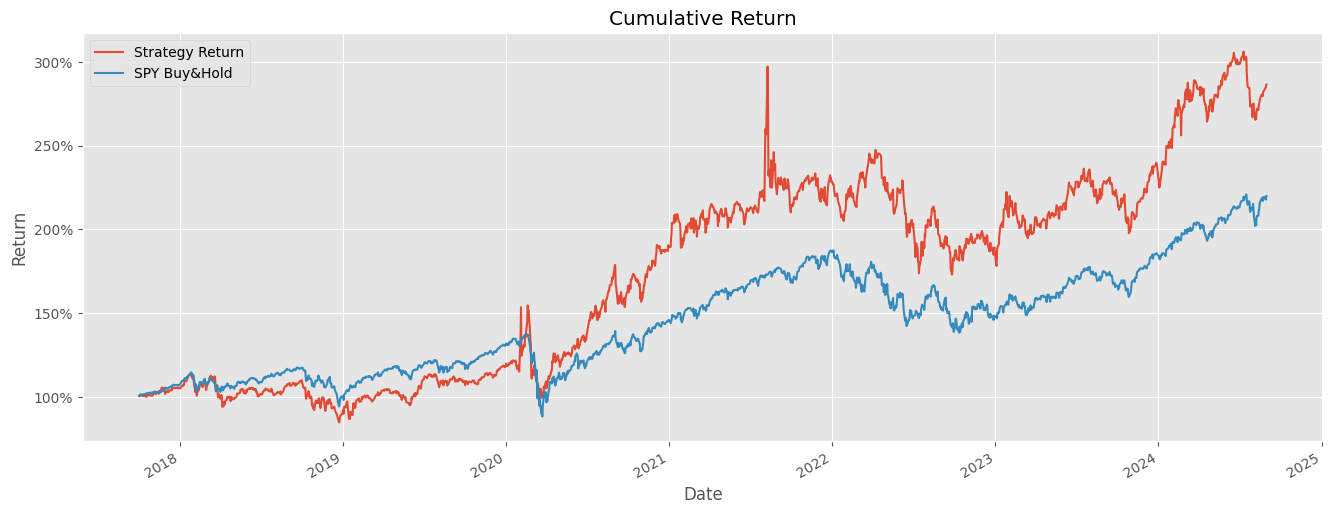

,Strategy Return,SPY Buy&Hold
Date,,
2017-10-02,1.005091,1.004329
2017-10-03,1.007008,1.006476
2017-10-04,1.005497,1.007670
2017-10-05,1.014002,1.013622
2017-10-06,1.009607,1.012468
...,...,...
2024-08-26,2.834222,2.187842
2024-08-27,2.842839,2.190844
2024-08-28,2.846321,2.178089


In [27]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())

portfolio_cumulative_return.plot(figsize=(16,6))

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')
plt.title('Cumulative Return')


plt.show()
portfolio_cumulative_return

##9. Closing

This analysis demonstrates the potential of technical analysis and momentum-based investing strategies, such as those leveraging the Relative Strength Index (RSI), to outperform benchmarks like the S&P 500. While this approach showed significant success over the past 7 years with a return of nearly 200%, it is important to recognize the challenges of sustaining such performance over longer periods.

As market conditions change, even the largest hedge funds, with vast resources and sophisticated strategies, often struggle to consistently beat the market. Therefore, while momentum strategies can generate large returns in the short to medium term, long-term success requires continuous adaptation and risk management.